# QUBO models from GULP

- [Read the structures](#structures)
- [Geometry analysis](#geom_analysis)
    - [Li distribution](#li_distribution)
    - [Mn distribution](#mn_distribution) small std
    - [O distribution](#o_distribution) small std
- [Build the QUBO model](#build_qubo_ml)
- [Symmetry analysis](#symm_analysis)

- [Build the QUBO matrix](#build_qubo_ip)
    - [Ewald](#ewald)
    - [Buckingham](#buckingham)
- [Calculate the energy of GULP structures](#calc_E)
- [Build the initial QUBO](#qubo)
- [Experiments](#experiments)    
- [Mgo/ZnO](#mgo_zno)

###  CATHY'S PROJECT
Things to fix
- The QUBO matrix gives large mse

Parameters to test:
- Li distribution (For these find some metrics to analyse the model)
    - use denser/less dense grid
    - train on low concentration/high concentration separately. Then merge them in the same model.
    - number of samples

- Building the QUBO model:
    - max_radius
    - reg = LinearRegression(fit_intercept=False)

- Mapping to hardware (plots and images from the D-Wave visualiser). For this you'll have to learn how to build a bqm from the QUBO matrix and use minor-embedding (https://docs.ocean.dwavesys.com/en/stable/concepts/embedding.html) and the EmbeddingComposite class (https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/composites.html#embeddingcomposite):
    - number of qubits and chain length vs Li grid size and number of QUBO elements (max_radius)

If you find a reasonable model you can try to run it on the hardware

Plots:
- standard deviation of Mn and O positions


### IP APPROACH
- Use the Li coordinates from the mapping
- Build the Ewald+IP matrix for the whole structure (including O)
- Sum the Mn-O and Li-O terms into Mn and Li
- How to take into account the changing lattice vectors? Build matrices depending on the concentration

- Test if I can incluse NN only
- Solve using SA + MC (python implementation or neal)
 


### PAST IDEAS
- for a shorter project, use fixed lattice and only consider Li positions (no Tc). A next step considers the Tc too, but at fixed lattice positions. Build a simple model with the Li atoms in the high-concentration (octa) and low-concentration sites (tetra). This would be useful for practicing building the energy model, but it would require running more GULP calculations on fixed lattice. 
- first get the distribution analysis and then build the energy model
    - we will need to map the position of atoms in the geometry relaxed structures to positions in the QUBO model
        - we could use a scaling in the linear regression (LR) that is proportional to how much an atom has moved from the QUBO position
- for the energy model let's try both the manual IP method and the LR



## GLOSSARY
- coord_top (N_positions_final): these are the Li coordinates with the higher probability calculated by defining a grid and looking at random structures in the database. They are not symmetrised. They are given in fractional coordinates.
- symmetrised_coords (N_positions_final x N_symmops): symmetrised coord_top. These are obtained by applying the symmetry operators of the delithiated structure to the coord_top. They are folded back into the cell (fractional coordinates).
- averaged_symmetrised_coords: (depends on the threshold): we only keep the symmetrised_coords that are more than a "threshold" apart.

- mn_sites_coords: Mn3+ sites coordinates taken from the initial delithiated structure

- all_coordinates_final: these are all the coordinates (fractional) included in the final model for QUBO. It contains the Mn sites first and then the Li ones.

- averaged_li_indices: these are the indices where the Li atoms are found in each structure. It refers to the list of averaged_symmetrised_coords. So [1] means that the Li atom is in position 1 of the averaged_symmetrised_coords

- mn_indices: this tells us for each structure (one row in mn_indices) where the Mn3+ are.

- binary_compositions: each row is the composition for one of the structures in the train set. The first 24 elements are the Mn (so a 1 means it's Mn3+) sites and the rest is Li (so 1 means there is a Li atom in that site). 


In [1]:
from QG_functions import *

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from pymatgen.io.cif import *

from ase.visualize import view


from pymatgen.io.ase import AseAtomsAdaptor
import sys

import re
import shutil as sh
import pickle
from tqdm import tqdm


import copy
from sklearn.metrics import mean_squared_error 

#import dataframe_image as dfi

from scipy import constants
from scipy.spatial import KDTree, distance_matrix

import matplotlib.pyplot as plt

import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error as mse


k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
# print(k_b)
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

import seaborn as sns
import time
# from QG_functions import *

### The cell below creates the smaller database (only use when needed)

In [2]:
# import numpy as np
# import pickle
# from tqdm import tqdm

# num_samples = 400  # Select 500 structures
# M = 20  # Grid definition (not used in this code)
# N_positions_final = 100  # Not used here but kept for context

# for i in tqdm(range(1, 25), desc="Selecting Structures"):
#     # Load the original pickle file
#     with open(f'../QUBO_GULP_SAVE/data/database/config_size_{i}.pkl', 'rb') as file:
#         data = pickle.load(file)  # `data` is a dictionary

#     # Select 500 random structures
#     sampled_keys = np.random.choice(list(data.keys()), num_samples, replace=False)
#     sampled_data = {key: data[key] for key in sampled_keys}  # Keep only sampled structures

#     # Save the sampled structures back to the pickle file
#     with open(f'data/database/config_size_{i}.pkl', 'wb') as file:
#         pickle.dump(sampled_data, file)

# print("✅ Successfully saved 500 structures per file.")


# <a id='structures'>Read the structures</a>

In [184]:
fully_lithiated_structure_init = Structure.from_file('data/fully_lithiated_tmp.cif')
delithiated_structure_init = Structure.from_file('data/delithiated_tmp.cif')

In [185]:
n_sites = fully_lithiated_structure_init.num_sites
fully_lithiated_structure_init.translate_sites(np.arange(n_sites),[1,1,1],to_unit_cell=True)

vview(fully_lithiated_structure_init)

In [5]:
# # I don't think we need these functions
# def apply_periodic_boundary_conditions(coord):
#     """
#     Apply periodic boundary conditions to bring fractional coordinates within [0, 1).
#     """
#     return coord - np.floor(coord)

# def distance_with_pbc(fixed_pos, atom_pos, lattice, tolerance):
#     """
#     Compute the minimum distance between a fixed lattice position and an atom, 
#     accounting for periodic boundary conditions (PBC).
    
#     Parameters:
#     fixed_pos (np.array): Fractional coordinates of the fixed lattice position.
#     atom_pos (np.array): Fractional coordinates of the atom.
#     lattice (np.array): Lattice vectors (3x3 matrix).
#     tolerance (float): Tolerance to determine whether two points are close enough.
    
#     Returns:
#     bool: True if the distance between fixed_pos and atom_pos is within the tolerance.
#     """
#     # Shift atom position using periodic boundary conditions
#     delta = apply_periodic_boundary_conditions(atom_pos - fixed_pos)
    
#     # Convert to Cartesian coordinates
#     delta_cartesian = np.dot(delta, lattice)
    
#     # Compute distance in Cartesian coordinates
#     distance = np.linalg.norm(delta_cartesian)
    
#     return distance < tolerance

# def create_binary_vector(fixed_positions, atoms, lattice, tolerance=0.1):
#     """
#     Create a binary vector indicating whether an atom is present near each fixed lattice position.
    
#     Parameters:
#     fixed_positions (np.array): List of fixed lattice positions as fractional coordinates.
#     atoms (np.array): List of atomic positions as fractional coordinates.
#     lattice (np.array): Lattice vectors (3x3 matrix).
#     tolerance (float): Distance threshold for determining a match (default 0.1).
    
#     Returns:
#     binary_vector (np.array): A binary vector where 1 indicates an atom is near a fixed lattice position.
#     """
#     num_fixed_positions = len(fixed_positions)
#     binary_vector = np.zeros(num_fixed_positions, dtype=int)
    
#     for i, fixed_pos in enumerate(fixed_positions):
#         for atom_pos in atoms:
#             if distance_with_pbc(fixed_pos, atom_pos, lattice, tolerance):
#                 binary_vector[i] = 1
#                 break  # Once we find a match, we don't need to check other atoms for this fixed position
    
#     return binary_vector

# # Example usage:
# fixed_positions = np.array([[0.57385, 0.47843, 0.25002],  # Replace with full list
#                             [0.89053, 0.22843, 0.41668],
#                             [0.39053, 0.04394, 0.75002],
#                             # Add all fixed positions
#                             ])

# # Example atom positions
# atom_positions = np.array([[0.57385, 0.47843, 0.25002], 
#                            [0.891, 0.2285, 0.4167], 
#                            [0.390, 0.044, 0.750]])

# # Lattice vectors (example)
# lattice_vectors = np.array([[10, 0, 0], [0, 10, 0], [0, 0, 10]])

# # Create binary vector
# tolerance = 0.1  # Adjustable tolerance for distance comparison
# binary_vector = create_binary_vector(fixed_positions, atom_positions, lattice_vectors, tolerance)

# print(binary_vector)


## From database

the data in data/database/config_size_n.pkl are the pkl files for all (?) the structures that Kyu optimised. 

they contain both the initial and final structure (pre and post geometry relaxation)

data.keys() are int

In [6]:
with open('data/database/config_size_1.pkl', 'rb') as file:
    data = pickle.load(file)

# Print the loaded data to verify
data[list(data.keys())[0]]


{'initial': {'energy': -2947.30808963,
  'energy_ip': 499.06909695,
  'energy_long': -3446.37718658,
  'energy_long_real': -2135.94536095,
  'energy_long_imag': -1310.43182563,
  'lattice_vectors': [[8.872874, 0.0, 0.0],
   [0.0, 9.432501, 0.0],
   [0.0, 0.0, 8.565761]],
  'config': [['Tc', 'core', 0.620302, 0.243497, 0.083331],
   ['Mn', 'core', 0.620302, 0.743492, 0.750012],
   ['Mn', 'core', 0.1203, 0.506495, 0.416677],
   ['Mn', 'core', 0.837392, 0.493495, 0.250004],
   ['Mn', 'core', 0.620302, 0.743492, 0.083331],
   ['Mn', 'core', 0.620302, 0.243497, 0.416677],
   ['Mn', 'core', 0.337391, 0.756492, 0.916685],
   ['Mn', 'core', 0.837392, 0.493495, 0.916685],
   ['Mn', 'core', 0.837392, 0.993489, 0.916685],
   ['Mn', 'core', 0.837392, 0.493495, 0.583339],
   ['Mn', 'core', 0.1203, 0.0065, 0.416677],
   ['Mn', 'core', 0.337391, 0.256497, 0.583339],
   ['Mn', 'core', 0.337391, 0.756492, 0.583339],
   ['Mn', 'core', 0.620302, 0.243497, 0.750012],
   ['Mn', 'core', 0.837392, 0.993489, 

# <a id='geom_analysis'>Geometry analysis</a>
- deviation around perfect lattice site per Li concentration (Mn and O)
- find grid of points where Li are more likely to sit (3D probability map) 
    - need to define a very dense grid
    - use symmetry?

#### Important variables in the functions below

M: grid definition. This defines the initial grid. Each atom will be assigned to a cube within the cell. M is the number of division along each lattice parameter, so the final number of cubes is M**3
N_positions_final: the final number of coordinates. These are the top N_positions_final in terms of probability. The coordinate that is returned is the center of the cube, so all the points within the cube now have the center as coordinate.


#### Considerations

There cannot be more N_positions_final than grid points.
Do the final positions converge with the grid size increase?
If the grid is too fine, I end up with a lot of positions that are very close (?)
At the end I could average the points that are too close, but wouldn'it be like using a smaller grid? -> the grid size could represent the minimum separation between sites that I want to use.
We could simmetrise after all the above and keep the average if two atoms are too close.

#### TO DO

plot mse and R vs:
- sample size
- grid size
- num coordinates

### <a id='li_distribution'>Li distribution</a>

In [7]:
vview(Structure.from_sites(fully_lithiated_structure_init[0:24]))

Computing Li positions: 100%|██████████| 24/24 [00:01<00:00, 13.95it/s]


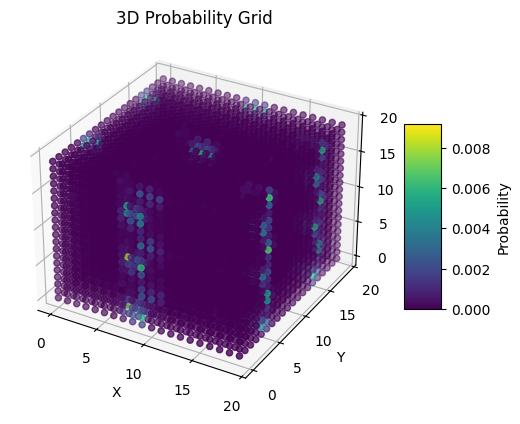

In [186]:
li_coords_all = []
num_samples = 100
M = 20 #grid definition
N_positions_final = 20

for i in tqdm(range(1,25), desc="Computing Li positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)
    
    structure_n = np.array(list(data.keys()))[samples]

    for i in structure_n:
        coords_tmp = np.array(data[i]['final']['config'])#[-48:])[:,2:]
        li_index = np.where(coords_tmp[:,0] == 'Li')[0]

        li_coords = np.array(coords_tmp[li_index][:,2:])
        li_coords = np.array(li_coords,dtype='float').tolist()
        li_coords_all.extend(li_coords)
        

li_coords_all = np.array(li_coords_all)
grid = compute_probability_grid(li_coords_all, M)

plot_probability_grid(grid)

centers = find_fractional_centers(M)
top_centers = find_top_x_points(grid,centers,N_positions_final)

coord_top = []
for line in top_centers:
    coord_top.append(line[0])
coord_top = np.array(coord_top)
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*N_positions_final,coord_top))



In [9]:
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*N_positions_final,coord_top))

## Apply symmetry operators to the Li top centers

In [187]:
symmops = SpacegroupAnalyzer(delithiated_structure_init).get_symmetry_operations()
num_symmops = len(symmops)

symmetrised_coords = []
for symmop in symmops:
    for coord in coord_top:
        symmetrised_coords.append(symmop.operate(coord)%1)


symmetrised_coords = np.array(symmetrised_coords)
len(symmetrised_coords)

960

In [188]:
threshold = 0.1  # THIS IS AN IMPORTANT PARAMETER

averaged_symmetrised_coords = average_close_points(symmetrised_coords, threshold)

print(len(averaged_symmetrised_coords))

47


In [189]:
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*len(averaged_symmetrised_coords),averaged_symmetrised_coords))

## Define the model

 This is the final sites included in the model. We define it here, but we might only need it for generating images.

In [ ]:
mn_sites = delithiated_structure_init[:] # This include all sites now (also O)
mn_sites_coords = delithiated_structure_init.frac_coords[:]

li_sites = []

for coord in averaged_symmetrised_coords:   
    li_sites.append(PeriodicSite('Li',coord,delithiated_structure_init.lattice)) 

li_sites_coords = copy.deepcopy(averaged_symmetrised_coords)


all_sites = copy.deepcopy(mn_sites)
all_sites.extend(li_sites)

all_coordinates_final = np.vstack((np.array(mn_sites_coords),averaged_symmetrised_coords))

final_model = Structure.from_sites(all_sites)


vview(Structure.from_sites(all_sites))

In [14]:
# I DON'T THINK WE NEED THIS
# mn_sites = delithiated_structure_init[0:24]
# mn_sites_coords = delithiated_structure_init.frac_coords[0:24]

# li_sites = []

# for coord in symmetrised_coords:   
#     li_sites.append(PeriodicSite('Li',coord,delithiated_structure_init.lattice)) 

# li_sites_coords = copy.deepcopy(averaged_symmetrised_coords)


# all_sites = copy.deepcopy(mn_sites)
# all_sites.extend(li_sites)

# final_model_all_symmetrised = Structure.from_sites(all_sites)

# vview(Structure.from_sites(all_sites))

## Find if structures map to our grid
Now that we have defined the Li coordinates to keep, I need to ensure that the GULP optimised structures map to those coordinates.

This is a good test, but we actually do it later when building the train set anyway.

In [15]:

tree_li = KDTree(li_sites_coords)  # Precompute KDTree
tree_mn = KDTree(mn_sites_coords)

In [16]:
li_coords_map = []
num_samples = 1

all_distances = []


threshold_dist = 0.1

for i in tqdm(range(1,3), desc="Computing Li positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    
    samples = np.random.choice(len(data), num_samples)
    structure_n = np.array(list(data.keys()))[samples]

    for i in structure_n:
        coords_tmp = np.array(data[i]['final']['config'])  # Extract structure data
        li_index = np.where(coords_tmp[:, 0] == 'Li')[0]  # Find Lithium positions

        li_coords = np.array(coords_tmp[li_index][:, 2:], dtype='float').tolist()

        # Compute closest distances and indices
        distances, indices = compute_closest_distances(li_coords, tree_li)
        print(indices)
        if np.any(distances > threshold_dist):
            break
        # Print results
        for i, (point, dist, idx) in enumerate(zip(li_coords, distances, indices)):
            closest_point = averaged_symmetrised_coords[idx]  # Retrieve the actual closest coordinate
            all_distances.append(dist)
            # print(f"Point {i}: {point} -> Closest Distance: {dist:.4f}, Closest Coord: {closest_point}, Index: {idx}")

Computing Li positions: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]

[29]
[30 31]


### <a id='mn_distribution'>Mn distribution</a>

I fixed this by sorting the coordinates (lexsort)

I am using fractional coordinates.


In [17]:
mn_coords_all = []
num_samples = 100 #MAKE RANDOM

for i in tqdm(range(1,25), desc="Computing Mn positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)

    structure_n = np.array(list(data.keys()))[samples]
    mn_coords_all = []
    for j in structure_n:
        coords_tmp = np.array(data[j]['initial']['config'])
        mn_coords_init = np.array(coords_tmp[0:24][:,2:]) 
        mn_coords_init = np.array(mn_coords_init,dtype='float')
        
        ordering = np.lexsort(mn_coords_init.T)
        
        coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
        mn_coords = np.array(coords_tmp[0:24][:,2:])

        mn_coords = np.array(mn_coords,dtype='float')
        mn_coords_ordered = np.array(mn_coords,dtype='float')[ordering]
        
        mn_coords_all.append(mn_coords_ordered.tolist())
        

    mn_coords_all = np.array(mn_coords_all)

Computing Mn positions: 100%|██████████| 24/24 [00:02<00:00,  9.57it/s]


#### Standard deviation of positions

In [18]:
np.std(mn_coords_all,axis=0)

array([[0.02590078, 0.02163773, 0.00529501],
       [0.01093411, 0.00782969, 0.00452913],
       [0.02467065, 0.0296401 , 0.00434745],
       [0.02568752, 0.03331688, 0.01746125],
       [0.03577725, 0.03226945, 0.01588741],
       [0.03258047, 0.00824438, 0.00475234],
       [0.00743889, 0.01299271, 0.00454101],
       [0.02603132, 0.48714092, 0.00492138],
       [0.03828734, 0.01245108, 0.00434645],
       [0.02688524, 0.0087449 , 0.00379272],
       [0.02503285, 0.01225111, 0.00454119],
       [0.04004917, 0.01919339, 0.00437801],
       [0.02705072, 0.02279723, 0.00453546],
       [0.0391863 , 0.04514442, 0.00672583],
       [0.03617036, 0.02163409, 0.00467065],
       [0.02952793, 0.48424007, 0.00460956],
       [0.04692916, 0.01282554, 0.00501912],
       [0.02958514, 0.02781696, 0.00432009],
       [0.00913843, 0.01216148, 0.00492004],
       [0.01600897, 0.02878686, 0.00432358],
       [0.01786463, 0.03480671, 0.00544573],
       [0.0320278 , 0.03182364, 0.00557999],
       [0.

### <a id='o_distribution'>O distribution</a>

#### Same approach as Mn

In [19]:
o_coords_all = []
num_samples = 100 #MAKE RANDOM

for i in tqdm(range(1,25), desc="Computing Mn positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)

    structure_n = np.array(list(data.keys()))[samples]
    o_coords_all = []
    for j in structure_n:
        coords_tmp = np.array(data[j]['initial']['config'])
        o_coords_init = np.array(coords_tmp[-48:][:,2:]) 
        o_coords_init = np.array(o_coords_init,dtype='float')
        
        ordering = np.lexsort(o_coords_init.T)
        
        coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
        o_coords = np.array(coords_tmp[-48:][:,2:])

        o_coords = np.array(o_coords,dtype='float')
        o_coords_ordered = np.array(o_coords,dtype='float')[ordering]
        
        o_coords_all.append(o_coords_ordered.tolist())
        

    o_coords_all = np.array(o_coords_all)

Computing Mn positions: 100%|██████████| 24/24 [00:02<00:00, 10.72it/s]


In [20]:
np.std(o_coords_all,axis=0)

array([[1.30025867e-02, 9.77705280e-03, 5.57544942e-03],
       [1.47044646e-02, 1.62290669e-02, 5.43182685e-03],
       [9.72431857e-03, 1.08586868e-02, 5.74924469e-03],
       [1.00342653e-02, 1.07072633e-02, 6.55035632e-03],
       [1.16271205e-02, 9.88566997e-03, 4.43620639e-03],
       [1.25442379e-02, 1.46442064e-02, 4.27338234e-03],
       [8.07168919e-03, 9.27508276e-03, 4.10813875e-03],
       [8.78212704e-03, 9.30779796e-03, 5.97386901e-03],
       [3.99732069e-01, 1.06391206e-02, 6.78504916e-03],
       [1.05790295e-02, 1.09357423e-02, 5.63334012e-03],
       [1.22777065e-02, 1.08314886e-02, 5.00464272e-03],
       [1.28900832e-02, 1.43914279e-02, 4.47631803e-03],
       [3.85769918e-01, 1.12469757e-02, 6.36941011e-03],
       [9.61341526e-03, 9.68458817e-03, 4.84094996e-03],
       [9.06374922e-03, 7.96131432e-03, 5.49295224e-03],
       [1.30870480e-02, 1.20746867e-02, 5.16590252e-03],
       [1.14543100e-02, 1.16094753e-02, 4.84124594e-03],
       [1.36602262e-02, 1.43146

# <a id='build_qubo_ml'>Build the QUBO model</a>

In [21]:
tree_li = KDTree(symmetrised_coords)
tree_li_average = KDTree(averaged_symmetrised_coords)

mn_sites_coords = delithiated_structure_init.frac_coords[0:24]

tree_mn = KDTree(mn_sites_coords)

symmops = SpacegroupAnalyzer(delithiated_structure_init).get_symmetry_operations()
n_symmops = len(symmops)

### Cathy exercise 2

function that generates the Li atom distribution

function generates the binary vectors (X_train and X_test)

function for test/train split

function to do LR to build QUBO

function to calculate the QUBO energies for X_test

YOU DO:




### Formation energies:
$$
E_r = E[\text{Li}_x\text{Mn}_x^{(3+)}\text{Mn}_{1-x}^{(4+)}\text{O}_2] - E[\text{MnO}_2] 
+ x (I_1^{\text{Li}} - I_4^{\text{Mn}} + E_{\text{corr}})
$$

**RMO Lithiation Reaction Energy Corrections**<sup>a</sup>

| parameters in [eq 2](#) | (eV)  |
|-------------------------|------:|
| $I_1^{\text{Li}}$       | 5.39171 |
| $I_4^{\text{Mn}}$       | 51.2   |
| $E_{\text{corr}}$       | 7.391  |

My calculation
$$
E[\text{MnO}_2] =  -3479.40750422947+496.08851796324404
$$

Kyu's GULP
$$
E[\text{MnO}_2] =  -3479.43334075+496.08285732
$$

In [22]:
import pickle
import numpy as np
from tqdm import tqdm

num_samples = 50  # Number of structures randomly sampled from each dataset

E_0 = -3479.43334075+496.08285732
I_Li = 5.39171
I_Mn = 51.2
E_corr = 7.391

# Lists to store extracted data
all_li_indices = []       # Stores indices of Li atoms after filtering
mn_indices = []        # Stores indices of Mn (Tc in this case) atoms
all_li_coordinates = []   # Stores Li atom coordinates after symmetry operations
all_energies = []      # Stores final energy values of selected structures
all_form_energies = []

# Loop over different dataset sizes/configurations (from 1 to 24)
for i in tqdm(range(1, 25), desc="Computing Li positions"):
    # Load the dataset for the given configuration size
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)

    # Randomly sample a subset of structures from the dataset
    samples = np.random.choice(len(data), num_samples)

    # Extract structure identifiers (keys) for the selected samples
    structure_n = np.array(list(data.keys()))[samples]

    # Iterate through selected structures
    for j in structure_n:
        # Extract final configuration coordinates
        coords_tmp = np.array(data[j]['final']['config'])  # Extracts coordinate data
        li_index = np.where(coords_tmp[:, 0] == 'Li')[0]  # Identify Li atom indices
        num_li_atoms = len(li_index)
        # Get coordinates of Li atoms in the structure
        li_coords = np.array(coords_tmp[li_index][:, 2:])  # Extract only coordinate values
        li_coords = np.array(li_coords, dtype='float').tolist()  # Convert to float and list format

        # Apply symmetry operations to Li coordinates
        li_symm_coords = apply_symmops(li_coords, symmops)

        # Compute the closest distances between symmetrized Li coordinates and a reference tree
        distances, indices = compute_closest_distances(li_symm_coords, tree_li)

        # Check if any distance is greater than a threshold (0.1), which may indicate an issue
        if np.any(distances > 0.5):
            print(f'Check distances structure {j} with conc {i}: max distance {np.max(distances)}')

        # Store indices and symmetrized coordinates of Li atoms
        all_li_indices.extend(indices)
        all_li_coordinates.extend(symmetrised_coords[indices])  # Ensure symmetrised_coords is defined correctly

        # Extract initial configuration coordinates for Mn (or Tc) atoms
        coords_tmp = np.array(data[j]['initial']['config'])  # Extract coordinate data
        mn_index = np.where(coords_tmp[:, 0] == 'Tc')[0]  # Identify Mn (Tc) atom indices

        # Get coordinates of Mn atoms in the structure
        mn_coords = np.array(coords_tmp[mn_index][:, 2:])  # Extract only coordinate values
        mn_coords = np.array(mn_coords, dtype='float').tolist()  # Convert to float and list format

        # Apply symmetry operations to Mn coordinates
        mn_symm_coords = apply_symmops(mn_coords, symmops)

        # Compute the closest distances between symmetrized Mn coordinates and a reference tree
        distances, indices = compute_closest_distances(mn_symm_coords, tree_mn)

        # Check if any Mn distance is greater than a threshold (0.01), which may indicate an issue
        if np.any(distances > 0.01):
            print(f'Check Mn distances structure {j} with conc {i}: max distance {np.max(distances)}')

        # Store Mn indices
        mn_indices.extend(indices)

        # Store the final energy of the structure
        # all_energies.append(float(data[j]['final']['energy']))
        energy_tmp = float(data[j]['final']['energy'])
        all_energies.extend([energy_tmp] * n_symmops)

        all_form_energies.extend([energy_tmp-E_0+num_li_atoms*(I_Li-I_Mn+E_corr)]* n_symmops)



Computing Li positions: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


In [23]:
# This has been defined above, but it's here too atm
threshold = 0.1  # THIS IS AN IMPORTANT PARAMETER

averaged_symmetrised_coords = average_close_points(symmetrised_coords, threshold)

print(len(averaged_symmetrised_coords))

64


The cell below maps the all_li_coordinates (that can be any of the symmetrised ones) to the reduced ones (the ones we kept in the definition of the model above)

In [24]:
averaged_li_indices = []
for coordinates in all_li_coordinates:
    distances, index = compute_closest_distances(coordinates, tree_li_average)
    if np.any(distances > 0.1):
        print(f'Check distances structure with conc : max distance {np.max(distances)}')
    averaged_li_indices.append(index)

## Build the binary vectors
TO DO: check the distances between points in symmetry equivalent points are constant

In [25]:
size_samples = len(mn_indices)
num_mn = 24
num_li = len(averaged_symmetrised_coords)
binary_compositions = np.zeros((size_samples,num_mn+num_li),dtype='int')

# Add Mn first
for i,index in enumerate(mn_indices):
    binary_compositions[i][index] = 1
for i,index in enumerate(averaged_li_indices):
    binary_compositions[i][index+num_mn] = 1

## Test/Train split

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

# Example: binary_compositions is a 2D NumPy array (N samples, M features)
# all_energies is a 1D list or NumPy array (N samples)
binary_compositions = np.array(binary_compositions)  # Ensure it's an array
all_form_energies = np.array(all_form_energies)  # Convert list to array if needed

# Define split ratio (e.g., test_size=0.2 for 20% test set)
test_ratio = 0.2  

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    binary_compositions, all_form_energies, test_size=test_ratio, random_state=42
)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (46080, 88), X_test shape: (11520, 88)
y_train shape: (46080,), y_test shape: (11520,)


### Build the QUBO model for real

In [27]:
def build_ml_qubo_test(distance_matrix,X_train,y_train,threshold=0.4):
    
    #  X_train are binary vectors
    
    num_sites = distance_matrix.shape[0]

    # Build the adjacency matrix (1 if distance <= threshold, 0 otherwise)
    adj_matrix = (distance_matrix <= threshold).astype(int)
 
    # Ensure diagonal is 0 (no self-loops)
    np.fill_diagonal(adj_matrix, 1)
    
    upper_tri_indices = np.where(adj_matrix != 0)

    descriptor = []
    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    print(descriptor.shape,len(y_train))
    from sklearn.linear_model import LinearRegression
    print("Adjacency matrix:\n", adj_matrix)
    print("Upper triangular indices:", upper_tri_indices)
    print("Descriptor shape:", descriptor.shape)
    print("Sample descriptor row:", descriptor[0])
    print("y_train:", y_train)
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q

In [28]:
structure_tmp = Structure(delithiated_structure_init.lattice,[1]*len(all_coordinates_final),all_coordinates_final)
dist_matrix = structure_tmp.distance_matrix

Q = build_ml_qubo(dist_matrix,X_train,y_train,threshold=10.)

(46080, 7744) 46080
R2:  0.9609241741258994


In [29]:
y_pred = get_qubo_energies(Q,X_train)
test_qubo_energies(y_pred,y_train)

3663.2778212347844

In [30]:
y_train

array([-63.47951934, -81.92842821, -77.55628857, ..., -63.77527284,
       -76.76610068, -76.97945559], shape=(46080,))

In [31]:
dist_matrix = np.ones((10,10))*10
X_train = np.eye(10).astype('int')
y_train = [-10]*10
build_ml_qubo_test(dist_matrix,X_train,y_train,threshold=3.)

(10, 10) 10
Adjacency matrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]
Upper triangular indices: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
Descriptor shape: (10, 10)
Sample descriptor row: [1 0 0 0 0 0 0 0 0 0]
y_train: [-10, -10, -10, -10, -10, -10, -10, -10, -10, -10]
R2:  1.0


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# THE END

In [32]:
raise RuntimeError("Execution stopped intentionally.")

RuntimeError: Execution stopped intentionally.

# <a id='build_qubo_ip'>Build the QUBO matrix (IP)</a>

In [2]:
# USE THIS
def max_lattice_translation_old(lattice_vectors, R_max):
    # Calculate the maximum rnx, rny, and rnz
    norm_0 = np.linalg.norm(lattice_vectors[0])
    norm_1 = np.linalg.norm(lattice_vectors[1])
    norm_2 = np.linalg.norm(lattice_vectors[2])
    
    max_rnx = int(R_max / norm_0)
    max_rny = int(R_max / norm_1)
    max_rnz = int(R_max / norm_2)
    
    max_rnx, max_rny, max_rnz = np.meshgrid(np.arange(-max_rnx, max_rnx+1),
                                            np.arange(-max_rny, max_rny+1),
                                            np.arange(-max_rnz, max_rnz+1),
                                            indexing='ij')
    
    shifts = (max_rnx[..., np.newaxis] * lattice_vectors[0] + 
              max_rny[..., np.newaxis] * lattice_vectors[1] + 
              max_rnz[..., np.newaxis] * lattice_vectors[2])
    
    shift_norms = np.linalg.norm(shifts, axis=-1)
    
    valid_indices = np.where(shift_norms <= R_max)
    
    max_translation = np.array([max_rnx[valid_indices].max(),
                                max_rny[valid_indices].max(),
                                max_rnz[valid_indices].max()])
    
    return max_translation

def compute_ewald_matrix(structure, sigma=None, R_max=None, G_max=None, 

                         max_shift = None,charge=None,w=1,print_info=False, triu=False, 
                         distance_analysis = False, distance_threshold = 0.1):
    """
    Parameters:
    frac_coords (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).
    sigma (float): Ewald parameter controlling the split between real and reciprocal sums. If None, it's calculated.
    max_shift (int): Depth of the real and reciprocal space summation.
    reciprocal_depth (int): Depth of the reciprocal space summation.
    charge (ndarray): charges of the system (Nx1).

    Returns:
    ndarray: Ewald summation matrix (NxN).
    """
    from numpy.linalg import norm
    
    TO_EV = 14.39964390675221758120
    
    t0 = time.time()
    
    frac_coords = structure.frac_coords
    lattice_vectors = structure.lattice.matrix
    distance_matrix = structure.distance_matrix

    N = len(frac_coords)
    V = np.linalg.det(lattice_vectors)
    
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T
    
    
    # Calculate alpha if not provided
    if sigma is None:
        Sigma = ((N * w * np.pi**3) / V**2)**(-1/6)
        
    alpha = np.sqrt(1/Sigma)
    

    A = 1e-17 
    f = np.sqrt(-np.log(A))

    # Calculate R_max and G_max
    if R_max == None:
        R_max = f * np.sqrt(alpha)
        R_max = np.sqrt(-np.log(A)*Sigma**2)
    
    if G_max == None:
        G_max = 2 * f * np.sqrt(alpha)
        G_max = 2/Sigma * np.sqrt(-np.log(A))

    
    
    cart_coords = frac_coords @ lattice_vectors
    
    
    if max_shift == None:
        real_space_max = max_lattice_translation_old(lattice_vectors,R_max)
        reci_space_max = max_lattice_translation_old(reciprocal_vectors,G_max)
    
        real_reci_space_max = np.maximum(real_space_max,reci_space_max)
        
        nx = real_reci_space_max[0]
        ny = real_reci_space_max[1]
        nz = real_reci_space_max[2]
        # print(nx,ny,nz)
    else:
        nx = ny = nz = max_shift # To improve
    
    # Main computation
    

    
    Real_E = Reci_E = 0.
    
    Ewald_real = np.zeros((N,N))
    Ewald_recip = np.zeros((N,N))
    Ewald_recip_self = np.zeros((N,N))
    
    if print_info == True:
        print('reciprocal_vectors\n',reciprocal_vectors)

        print(f'Volume = {V}')
        print(f'w={w}')
        
        print(f'alpha= {alpha}, sigma={Sigma},R_max = {R_max}, G_max = {G_max}')
        print(f'Charge = {charge}')
        
        #print('Cart coords\n',cart_coords)
        print(f'Max vectors = {nx},{ny},{nz}')

    for i in tqdm(range(N), desc="Computing real space"):
        for j in range(i,N):
            dr = cart_coords[i]-cart_coords[j]
            dr_dm = distance_matrix[i][j]

            if i != j and  distance_analysis == True and dr_dm < distance_threshold:
                Ewald_real[i,j] = 1e6
                print(i,j,np.linalg.norm(dr),dr_dm)
            else:    
                dr_init = cart_coords[i]-cart_coords[j]
                dr_frac = frac_coords[i]-frac_coords[j]

                for rnx in range(-nx, nx + 1):
                    for rny in range(-ny, ny + 1):
                        for rnz in range(-nz, nz + 1):

                            lattice_translation = np.array([rnx, rny, rnz])

                            shift = rnx*lattice_vectors[0]+rny*lattice_vectors[1]+rnz*lattice_vectors[2]
                            if np.linalg.norm(shift) < R_max:
                                dr = dr_init + shift

                                if np.all(lattice_translation == 0):

                                    if i != j:
                                        Ewald_real[i,j] += 0.5 / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
#                                         Real_E          += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
                                    else:
                                        Ewald_recip_self[i,j] += -1 / Sigma / math.sqrt(np.pi) * TO_EV


                                else:

                                    Ewald_real[i,j] += 0.5 / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
#                                     Real_E          += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV

                                # Reciprocal sum

                            gr = rnx*reciprocal_vectors[0]+rny*reciprocal_vectors[1]+rnz*reciprocal_vectors[2]
                            if np.linalg.norm(gr) < G_max:

                                if np.any(lattice_translation != 0):
                                    g_2 = np.dot(gr, gr)

#                                     Reci_E += TO_EV * (2 * np.pi / V) * (charge[i] * charge[j]) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(np.dot(gr, dr))
                                    Ewald_recip[i,j] +=  TO_EV * (2 * np.pi / V) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(np.dot(gr, dr))

    Ewald_full = Ewald_real+Ewald_recip+Ewald_recip_self
    
    for i in np.arange(N):
        for j in np.arange(i):
            Ewald_full[i, j] = Ewald_full[j, i]
            
    if triu == True:
        Ewald_tmp = np.triu(Ewald_full)*2
        np.fill_diagonal(Ewald_tmp,Ewald_full.diagonal())
        Ewald_full = np.copy(Ewald_tmp)
    
#     Reci_self = sum(-(charge[i]**2) / Sigma / math.sqrt(np.pi) * TO_EV for i in range(N))
    
    if print_info == True:
        
        print(f"Real sum: {Real_E:.8f} eV")
        print(f"Reciprocal sum: {Reci_E:.8f} eV")
        print(f"Reciprocal self (eV): {Reci_self:.16f}")
        print(f"Reciprocal (eV): {Reci_self + Reci_E:.16f}")
        print(f"Total (eV): {Real_E + Reci_E + Reci_self:.16f}")
    
    return Ewald_full


def calculate_potential_energy(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
    
    charges = np.array(charges)
    
    
    return  charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix

In [3]:
def buckingham_potential(param, r):
    """
    Calculate the Buckingham potential for a given distance.

    Parameters:
    A (float): Constant A in the Buckingham potential equation.
    Rho (float): Constant Rho in the Buckingham potential equation.
    C (float): Constant C in the Buckingham potential equation.
    r (float): Distance between two atoms.

    Returns:
    float: Potential energy at distance r.
    """
    A = param[0]
    Rho = param[1]
    C = param[2]
    
    V = A * np.exp(-r / Rho) - C / r**6
    return V


In [4]:
#python
def compute_buckingham_matrix(structure, buckingham_dict, R_max, max_shift=None, 
                              distance_analysis = False, distance_threshold = 0.1):
    """
    Compute the Buckingham potential matrix for a system of particles.

    Parameters:
    positions (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).

    """
    frac_coords = structure.frac_coords
    lattice_vectors = structure.lattice.matrix
    sites = structure.sites
    distance_matrix = structure.distance_matrix
    
    TO_EV = 14.39964390675221758120
    
    t0 = time.time()
    
    N = structure.num_sites
    V = np.linalg.det(lattice_vectors)
    
    cart_coords = frac_coords @ lattice_vectors
    
    if max_shift == None:
        max_real = max_lattice_translation_old(lattice_vectors, R_max)
        nx = max_real[0]
        ny = max_real[1]
        nz = max_real[2]
    else:
        ny = nz = nx = max_shift
    #print(f'Max vectors = {nx},{ny},{nz}')
    buckingham_matrix = np.zeros((N,N))
    
    for i in tqdm(range(N), desc="Buckingham matrix"):
        for j in range(i+1,N):
            
            sites_label = f'{sites[i].specie}-{sites[j].specie}'
            if sites_label in buckingham_dict:
                dr_init = cart_coords[i]-cart_coords[j]
                dr_dm = distance_matrix[i][j]
                if i != j and distance_analysis == True and dr_dm < distance_threshold:
                    buckingham_matrix[i,j] = 1e6
                else:
                    for rnx in range(-nx, nx + 1):
                        for rny in range(-ny, ny + 1):
                            for rnz in range(-nz, nz + 1):

                                lattice_translation = np.array([rnx, rny, rnz])

                                shift = rnx*lattice_vectors[0]+rny*lattice_vectors[1]+rnz*lattice_vectors[2]
                                dr = dr_init + shift
                                if np.linalg.norm(dr) < R_max:
                                    dr = dr_init + shift
    #                                 print(dr,np.linalg.norm(dr), buckingham_dict[sites_label],buckingham_potential(buckingham_dict[sites_label],
    #                                                                          np.linalg.norm(dr)))
                                    buckingham_matrix[i][j] += buckingham_potential(buckingham_dict[sites_label],
                                                                         np.linalg.norm(dr))
    return buckingham_matrix


## Test IP functions

In [6]:
i = 1
with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
    data = pickle.load(file)
structure_test = db_to_structure(data[list(data.keys())[0]])

In [7]:
atomic_numbers = np.array(structure_test.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                25:+4,
                8:-2
}

buckingham_dict = {'Li-O':[426.480 ,    0.3000  ,   0.00],
                   'Mn-O':[3087.826    ,   0.2642 ,    0.00], 
                   'Tc-O':[1686.125  ,    0.2962 ,    0.00],
                   'O-O' : [22.410  ,     0.6937,   32.32]
                  }

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
print(charges) 
time_init = time.time()
ewald_matrix = compute_ewald_matrix(structure_test,sigma=None,max_shift = None,
                                    w=0.123,triu=True, distance_analysis=True)#,R_max=15, G_max=15,max_shift = 5)
# print(f'Total time: {time.time()-time_init}')
compute_buckingham_matrix(structure_test, buckingham_dict, R_max=25, max_shift=None, 
                              distance_analysis = False, distance_threshold = 0.1)
print(f'Total time: {time.time()-time_init}')
#                                     R_max=15, G_max=15, max_shift = 10)
#np.sum(calculate_potential_energy(ewald_matrix,charges))

[ 3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  1. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2.]


Buckingham matrix: 100%|██████████| 73/73 [00:01<00:00, 42.76it/s]

Total time: 28.843833208084106


In [ ]:
structure = copy.deepcopy(structure_test)
structure[0] = 'Mn'
ewald_matrix = compute_ewald_matrix(structure,sigma=None,max_shift = None,
                                    w=0.123,triu=True, distance_analysis=True,
                                    distance_threshold=0.1)

Computing real space: 100%|██████████| 73/73 [00:29<00:00,  2.47it/s]


In [17]:
mn_indices

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),)

In [24]:
atomic_numbers = np.array(structure_test.atomic_numbers)

mn_indices = np.where((atomic_numbers == 23) | (atomic_numbers == 25))[0]
li_indices = np.where((atomic_numbers == 3))[0]
o_indices = np.where((atomic_numbers == 8))[0]
expanded_ewald_matrix = expand_ewald_matrix(ewald_matrix, mn_indices)

In [20]:
weighted_ewald = build_charge_weighted_ewald(structure_test, expanded_ewald_matrix)

In [25]:
final_ewald,oxygen_energy = project_and_remove_oxygen(weighted_ewald, structure_test, mn_indices, li_indices, o_indices)

In [29]:
binary_vector = generate_binary_array(
    mn_indices, li_indices)
print(binary_vector)

binary_vector = generate_random_binary_array(
    mn_indices, li_indices, n_active=1, seed=133)

print(binary_vector)



[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1
 0 1 0 1 0 1 0 1 0 1]


### Buckingham discrete

In [ ]:
# Example data (simplified)
atomic_numbers = np.array(structure.atomic_numbers)
coordinates = structure.frac_coords  # Random coordinates for 6 atoms


# Expand atomic structure
expanded_atomic_numbers, expanded_coordinates = expand_atomic_structure(atomic_numbers, coordinates, mn_indices)

structure_new = Structure(structure.lattice,expanded_atomic_numbers,expanded_coordinates)

buckingham_dict = {'Li-O':[426.480 ,    0.3000  ,   0.00],
                    'Mn-O':[3087.826    ,   0.2642 ,    0.00], # This is the Mn4+
                   'Tc-O':[1686.125  ,    0.2962 ,    0.00], 
                   'O-O' : [22.410  ,     0.6937,   32.32]
                  }
    
ip_matrix_expanded = compute_buckingham_matrix(structure_new, buckingham_dict, 25, 
                                             max_shift=None, distance_analysis = False, 
                                             distance_threshold = 0.1)

Buckingham matrix: 100%|██████████| 97/97 [00:02<00:00, 34.90it/s]


In [ ]:
expanded_atomic_numbers, expanded_coordinates = expand_atomic_structure(atomic_numbers, coordinates, mn_indices)
ip_matrix_expanded_reduced, oo_energy = project_and_remove_oxygen_from_buckingham(ip_matrix_expanded, expanded_atomic_numbers)

In [31]:
# I copied this into QC_functions, but I am keeping it here too atm
def build_qubo_limno_disc(structure, R_max_IP=25, sigma=None, R_max_Ewald=None, 
                     G_max=None, max_shift = None,w=0.123,print_info=False, triu=False, 
                         distance_analysis = False, distance_threshold = 0.1):
    
    # structure: pymatgen Structure than contains all the Li sites (and Mn and O)

    # Build the initial Ewald matrix

    ewald_matrix = compute_ewald_matrix(structure,sigma=sigma,max_shift = max_shift,
                                    w=w,triu=triu, distance_analysis=distance_analysis,
                                    distance_threshold=distance_threshold)
    
   
    # Make the Ewald matrix discrete in the Mn positions
    atomic_numbers = np.array(structure.atomic_numbers)
    num_sites = structure.num_sites
    frac_coordinates = structure.frac_coords  

    li_indices = np.where(atomic_numbers == 3)[0]
    mn_indices = np.where(atomic_numbers == 25)[0]
    o_indices = np.where(atomic_numbers == 8)[0]

    expanded_ewald_matrix = expand_ewald_matrix(ewald_matrix, mn_indices)

    # Multiply by the charges (+4, +3, +1 and -2)
    
    weighted_ewald = build_charge_weighted_ewald(structure, expanded_ewald_matrix)

    # Remove the oxygen, reduce the size of the matrix and get the O-O energy

    final_ewald, oo_ewald_energy = project_and_remove_oxygen(
        weighted_ewald, structure, mn_indices, li_indices, o_indices)
    

    # Expand atomic structure
    expanded_atomic_numbers, expanded_coordinates = expand_atomic_structure(
        atomic_numbers, frac_coordinates, mn_indices)


    structure_new = Structure(structure.lattice,expanded_atomic_numbers,
                              expanded_coordinates)

    buckingham_dict = {'Li-O':[426.480 ,    0.3000  ,   0.00],
                       'Mn-O':[3087.826    ,   0.2642 ,    0.00], # This is the Mn4+
                       'Tc-O':[1686.125  ,    0.2962 ,    0.00], # This is the Mn3+
                       'O-O' : [22.410  ,     0.6937,   32.32]
                       }
        
    ip_matrix_expanded = compute_buckingham_matrix(structure_new, buckingham_dict, 25, 
                                                max_shift=None, distance_analysis = False, 
                                                distance_threshold = 0.1)

    ip_matrix_expanded_reduced, oo_ip_energy = project_and_remove_oxygen_from_buckingham(
                    ip_matrix_expanded, expanded_atomic_numbers)
    
    Q_matrix = final_ewald + ip_matrix_expanded_reduced
    oo_energy = oo_ewald_energy + oo_ip_energy

    return Q_matrix, oo_energy

structure = copy.deepcopy(structure_test)
structure[0] = 'Mn'
Q_matrix, oo_energy = build_qubo_limno_disc(structure,sigma=None,max_shift = None,
                                    w=0.123,triu=True, distance_analysis=True,
                                    distance_threshold=0.1)

Buckingham matrix: 100%|██████████| 97/97 [00:02<00:00, 37.36it/s]


In [34]:
Q_matrix[-10]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  -22.67879191, -211.83327843,
         -0.78544149,   -0.58908112,   -2.01919731,   -1.51439798,
         -1.49233489,   -1.11925117,   11.19690872,    8.39768154,
          3.44663475])

In [30]:
Q_matrix, oo_energy = build_qubo_limno_disc(final_model,sigma=None,max_shift = None,
                                    w=0.123,triu=True, distance_analysis=True,
                                    distance_threshold=0.1)

NameError: name 'final_model' is not defined

### Distance matrix filter

In [461]:
mn_indices = np.where(np.array(final_model.atomic_numbers) == 25)[0]
li_indices = np.where(np.array(final_model.atomic_numbers) == 3)[0]

mn_sites_final = []
[mn_sites_final.append( final_model[i]) for i in  mn_indices]
li_sites_final = []
[li_sites_final.append( final_model[i]) for i in  li_indices]



all_sites_final = copy.deepcopy(mn_sites_final)
all_sites_final.extend(li_sites_final)

final_model_no_o = Structure.from_sites(all_sites_final)

final_model_no_o_dm = final_model_no_o.distance_matrix

nn_shift = (final_model_no_o_dm < 1) * 1e11
nn_shift = np.triu(nn_shift,1)
nn_shift_expanded = expand_ewald_matrix(nn_shift,mn_indices)
Q_matrix += nn_shift_expanded

In [1128]:
x = generate_random_binary_array(mn_indices, li_indices,n_active=24)

print(classical_energy(x, Q_matrix + nn_shift_expanded )+oo_energy)
print(x)

1259999999154.9673
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0
 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0]


## Plot the QUBO heat map

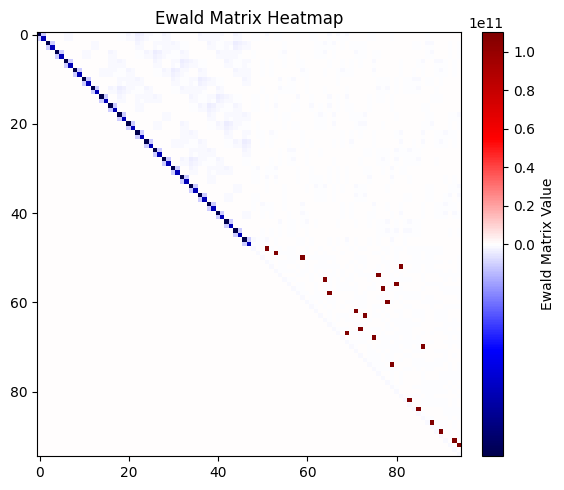

In [790]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Example Ewald matrix

# Plotting
fig, ax = plt.subplots(figsize=(6, 5))

# Use TwoSlopeNorm to center the colormap at 0 (white)
norm = TwoSlopeNorm(vmin=np.min(Q_matrix), vcenter=0, vmax=np.max(Q_matrix))

# Use 'seismic' or 'bwr' diverging colormap
cmap = plt.get_cmap('seismic')  # or 'bwr'

cax = ax.imshow(Q_matrix, cmap=cmap, norm=norm)

# Add colorbar
cbar = plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Ewald Matrix Value")

ax.set_title("Ewald Matrix Heatmap")
plt.tight_layout()
plt.show()